## Import required libraries

In [120]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt                        
%matplotlib inline 
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
from PIL import Image
import os
import glob
import math
import Augmentor
import matplotlib.image as mpimg

## Load data

In [2]:
tarin = pd.read_csv('./fashionmnist/fashion-mnist_train.csv')
test = pd.read_csv('./fashionmnist/fashion-mnist_test.csv')

In [3]:
tarin.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
test.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,9,8,...,103,87,56,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,34,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,14,53,99,...,0,0,0,0,63,53,31,0,0,0
3,2,0,0,0,0,0,0,0,0,0,...,137,126,140,0,133,224,222,56,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
tarin.describe()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
count,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,...,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.00000
mean,4.500000,0.000900,0.006150,0.035333,0.101933,0.247967,0.411467,0.805767,2.198283,5.682000,...,34.625400,23.300683,16.588267,17.869433,22.814817,17.911483,8.520633,2.753300,0.855517,0.07025
std,2.872305,0.094689,0.271011,1.222324,2.452871,4.306912,5.836188,8.215169,14.093378,23.819481,...,57.545242,48.854427,41.979611,43.966032,51.830477,45.149388,29.614859,17.397652,9.356960,2.12587
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
50%,4.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
75%,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,58.000000,9.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
max,9.000000,16.000000,36.000000,226.000000,164.000000,227.000000,230.000000,224.000000,255.000000,254.000000,...,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,170.00000


In [6]:
tarin.nunique()['label']

10

## Visualize Data

In [62]:
def display(n):
    x = np.array(tarin.drop(columns=['label']))[n]
    y = np.array(tarin['label'])[n]
    #reshape into 28*28
    x = x.reshape([28,28]).astype('float32')
    img = Image.fromarray(x).convert('L')
    x = np.asarray(img)
    plt.title("Image Number %d , Lable : %d" % (n,y))
    plt.imshow(x, cmap= plt.get_cmap('gray'))

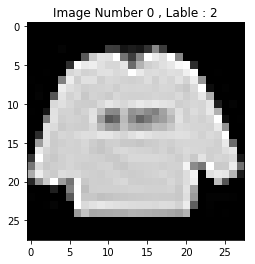

In [63]:
display(0)

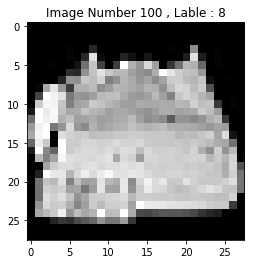

In [64]:
display(100)

## Save all images into ./data/{res.class} for further use - coversion from csv to png

In [71]:
def save_as_image():
    i = 0
    for lal,img in zip(tarin['label'],np.array(tarin.drop(columns=['label'])).astype('float32')):
        new_image = Image.fromarray(img.reshape(28,28))
        new_image = new_image.convert("L")
        dir_ = 'data/' + str(lal)
        if not os.path.exists(dir_):
            os.makedirs(dir_)
        new_image.save(dir_ + '/'+str(i)+'.png')
        i += 1
        
save_as_image()

**OBSERVATIONS :**

* There are 10 diffrent classes
* 784 pixels 28*28 img b/w image (1 channel)
* each pixel value ranges from 0 to 255

In [9]:
train_y = tarin['label']
train_x = tarin.drop(columns=['label'])

In [11]:
test_y = test['label']
test_x = test.drop(columns=['label'])

## Preprocess Data

### Normalize

In [12]:
train_x = train_x.astype('float32')/255
test_x = test_x.astype('float32')/255

In [13]:
train_x.describe()

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
count,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,...,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000
mean,0.000004,0.000024,0.000139,0.000400,0.000972,0.001614,0.003160,0.008621,0.022282,0.056819,...,0.135786,0.091375,0.065052,0.070076,0.089470,0.070241,0.033414,0.010797,0.003355,0.000275
std,0.000371,0.001063,0.004793,0.009619,0.016890,0.022887,0.032216,0.055268,0.093410,0.150332,...,0.225668,0.191586,0.164626,0.172416,0.203257,0.177056,0.116137,0.068226,0.036694,0.008337
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.227451,0.035294,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,0.062745,0.141176,0.886275,0.643137,0.890196,0.901961,0.878431,1.000000,0.996078,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.666667


In [14]:
test_x.describe()

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,...,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,0.000002,0.000040,0.000204,0.000302,0.000818,0.001369,0.003242,0.009103,0.021403,0.056327,...,0.134591,0.090478,0.064439,0.070081,0.089647,0.069765,0.032759,0.009967,0.002469,0.000257
std,0.000096,0.002060,0.009782,0.008662,0.018311,0.022188,0.033693,0.058947,0.091604,0.148673,...,0.227014,0.192352,0.165332,0.173100,0.202771,0.176973,0.112807,0.064382,0.029265,0.007584
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.215686,0.023529,0.000000,0.000000,0.003922,0.000000,0.000000,0.000000,0.000000,0.000000
max,0.007843,0.176471,0.854902,0.725490,0.890196,0.874510,0.968627,0.854902,0.956863,0.980392,...,0.996078,0.988235,1.000000,1.000000,1.000000,1.000000,0.941176,0.882353,0.803922,0.419608


In [20]:
train_y.describe()

,0,1,2,3,4,5,6,7,8,9
count,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000
mean,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000
std,0.300003,0.300003,0.300003,0.300003,0.300003,0.300003,0.300003,0.300003,0.300003,0.300003
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [19]:
test_y.describe()

,0,1,2,3,4,5,6,7,8,9
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000
std,0.300015,0.300015,0.300015,0.300015,0.300015,0.300015,0.300015,0.300015,0.300015,0.300015
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### ONE HOT ENCODING

In [17]:
train_y = pd.get_dummies(train_y)
test_y = pd.get_dummies(test_y)

In [15]:
train_y.head()

0    2
1    9
2    6
3    0
4    3
Name: label, dtype: int64

In [18]:
test_y.head()

,0,1,2,3,4,5,6,7,8,9
0,1,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0


### Reshape Data

In [16]:
train_x = np.array(train_x).reshape(-1,28,28,1)
test_x = np.array(test_x).reshape(-1,28,28,1)

### Split into train and validation

In [21]:
train_x , val_x, train_y, val_y = train_test_split(train_x, train_y, test_size=0.2)

In [22]:
### Verify len

In [23]:
len(train_x), len(val_x) , len(train_y) , len(val_y)

(48000, 12000, 48000, 12000)

I have made use of **Deep Convolution Neural Networks** to solve the given challenge.The approach to solve this problem is to bulid a CNN from scratch.

I strongly fell CNN would be the right choice for solving this problem because the input data is an image and the for any pixel its immediate neighbour pixels play more role in determining the feature that the pixel that is far away. Convolution helps us in caputing this feature, thus DCNN are the best network to solve this problem

## Challange A : MULTI LABLE CLASSIFICTION OF MNIST FASHION DATASET

### Model Architecture

In [24]:
model = Sequential()

model.add(Conv2D(filters=16, kernel_size=2, padding='same', activation='relu',input_shape=(train_x.shape[1:]) ))
model.add(MaxPooling2D(pool_size=3))

model.add(Dropout(0.2))
model.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))

model.add(Dropout(0.2))
model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(filters=128, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))

model.add(GlobalAveragePooling2D(data_format=None))
model.add(Dense(256, activation='relu'))

model.add(Dropout(0.2))
model.add(Dense(256, activation='relu'))

model.add(Dropout(0.2))
model.add(Dense(train_y.shape[1], activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 16)        80        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 9, 9, 16)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 9, 9, 16)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 9, 9, 32)          2080      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 32)          0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 4, 4, 32)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 64)          8256      
__________

The model consits of 5 Conv2D layer with diffrent filter size, growing as we go deeper in the network. These are followed by global average pooling layer making sure only necessary features are going to next layer. It is follwed by two dense layer which is used for calssification.

Droupouts were added where ever required to avoid overfitting

### Compile the Model

In [31]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

I have choosen **rmsprop** as optimizer as it can automatically adjust step size and thus performing better than other optimizers.

For the loss function I have gone with **categorical crossentropy** since we are dealing with categorical data (classification)

FOr the metrics I have gone with **accuracy** as it gives us the best view of how our model performs ( Since our test data contains equal mix of all classes )

### Train the Model


In [33]:
## specify the number of epochs that you would like to use to train the model.

epochs = 40


checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)

model.fit(train_x, train_y, 
          validation_data=(val_x, val_y),
          epochs=epochs, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 48000 samples, validate on 12000 samples
Epoch 1/40
48000/48000 [==============================] - 13s 269us/step - loss: 0.5503 - acc: 0.7959 - val_loss: 0.4496 - val_acc: 0.8353

Epoch 00001: val_loss improved from inf to 0.44964, saving model to saved_models/weights.best.from_scratch.hdf5
Epoch 2/40
48000/48000 [==============================] - 13s 276us/step - loss: 0.5391 - acc: 0.8092 - val_loss: 0.4675 - val_acc: 0.8357

Epoch 00002: val_loss did not improve from 0.44964
Epoch 3/40
48000/48000 [==============================] - 12s 259us/step - loss: 0.5412 - acc: 0.8120 - val_loss: 0.4362 - val_acc: 0.8373

Epoch 00003: val_loss improved from 0.44964 to 0.43619, saving model to saved_models/weights.best.from_scratch.hdf5
Epoch 4/40
48000/48000 [==============================] - 12s 255us/step - loss: 0.5627 - acc: 0.8067 - val_loss: 0.4586 - val_acc: 0.8349

Epoch 00004: val_loss did not improve from 0.43619
Epoch 5/40
48000/48000 [==============================] - 13

### Load Model with best validation loss

In [50]:
model.load_weights('saved_models/weights.best.from_scratch.hdf5')

### Test the Model

In [51]:
# get index of predicted class for each image in test set
predictions = [np.argmax(model.predict(np.expand_dims(x, axis=0))) for x in test_x]

# report test accuracy
test_accuracy = 100*np.sum(np.array(predictions)==np.argmax(np.array(test_y), axis=1))/len(test_x)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 85.4300%


Therefore the model build from scratch gave a Test accuracy of **85.4300%**

# Challange B : MNIST FASHION IMAGE SYNTHESIS

To generate synthetic data I have figured out two ways. First one is by introducing **distortion** in the image, the second one is use of **Generative Adversarial Networks**

## Method 1 : Apply distortion to existing image

The folder data/augmentation contatins 31 sample images for augmentation

In [135]:
p = Augmentor.Pipeline("data/augmentation")
p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
p.random_distortion(probability=0.3, grid_height=28, grid_width=28, magnitude=1)
p.sample(16)

Initialised with 31 image(s) found.
Output directory set to data/augmentation\output.

Processing <PIL.Image.Image image mode=L size=28x28 at 0x29E0825BEB8>: 100%|█████| 16/16 [00:00<00:00, 89.61 Samples/s]            


To generate image by applying augmentation. I have gone with roation with probability of 0.7 and elastic distortion with a probability of 0.3

In [136]:
imgs = glob.glob('data/augmentation/output/*.png')

Visualize the augmented images

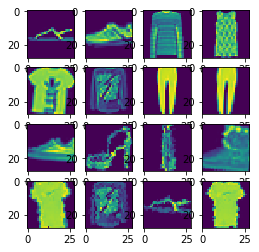

In [137]:
fig=plt.figure(figsize=(4, 4))
columns = 4
rows = 4
for i in range(1, columns*rows +1):
    img =  mpimg.imread(imgs[i-1])
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

## Method 2 : USING DCGAN's

function to create TF Placeholders for the Neural Network. It should create the following placeholders

The GAN consists of two networks. The first one is genrator and the second one is discriminator. The networks compete with each other and try to out perform other thus gainning a optimal network. Since I have trained the discriminator network to classify / discriminate based on MNIST Fashion Dataset, the trainned genratoe network tries to outform and produces images similar to MNIST Fashion Dataset.

For the loss I have gone with cross entropy since we are dealing with classification for discriminator.

For the optimizer I have gone with Adam since it gave me better results when compared with its alternatives.

I have written functions to create a network. The brief description of the function is given below the function

In [26]:
def model_inputs(image_width, image_height, image_channels, z_dim):
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name="input_real")
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, (),name = 'learning_rate')
    
    return inputs_real, inputs_z, learning_rate

function to create a discriminator neural network that discriminates on images.

In [27]:
def discriminator(images, reuse=False):    
    alpha = 0.1
    keep_prob = 0.9
    
    with tf.variable_scope('discriminator', reuse=reuse):
        x1 = tf.layers.conv2d(images, 64, 3, strides=2, padding='same')
        x1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d(x1, 128, 3, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(alpha * x2, x2)
        
        x3 = tf.layers.conv2d(x2, 256, 3, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(alpha * x3, x3)
        
        x4 = tf.reshape(x3, (-1,  4 * 4 * 256))
        logits = tf.layers.dense(x4, 1)
        logits = tf.layers.dropout(logits, rate=0.5)
        out = tf.sigmoid(logits)
        
        return out, logits

function generator to generate an image.

In [28]:
def generator(z, out_channel_dim, is_train=True):
    alpha = 0.1
    keep_prob = 0.9
    
    with tf.variable_scope('generator', reuse=not is_train):
        g1 = tf.layers.dense(z, 7*7*512)
        g1 = tf.reshape(g1, (-1, 7, 7, 512))
        g1 = tf.layers.batch_normalization(g1, training=is_train)
        g1 = tf.maximum(alpha * g1, g1)
        # 7x7x512
        
        g2 = tf.layers.conv2d_transpose(g1, 256, 5, strides=2, padding='same')
        g2 = tf.layers.batch_normalization(g2, training=is_train)
        g2 = tf.maximum(alpha * g2, g2)
        # 14x14x256
        
        g3 = tf.layers.conv2d_transpose(g2, 128, 5, strides=2, padding='same')
        g3 = tf.layers.batch_normalization(g3, training=is_train)
        g3 = tf.maximum(alpha * g3, g3)
        # 28x28x128
        
        logits = tf.layers.conv2d_transpose(g3, out_channel_dim, 4, strides=1, padding='same')
        # 28x28xout_channel_dim
        
        out = tf.tanh(logits)
        
        return out

build the GANs for training and calculate the loss

In [29]:
def model_loss(input_real, input_z, out_channel_dim):
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real) * 0.9))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))    
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss

function to create the optimization operations for the GANs

In [30]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimizers
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

 function to show the current output of the generator during training

In [98]:
def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = images_square_grid(samples, image_mode)
    
    plt.imshow(images_grid, cmap=cmap)
    plt.show()

function to train the DCGAN

In [32]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    
    _, image_width, image_height, image_channels = data_shape
    input_real, input_z, lr = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    saver = tf.train.Saver()

    losses = []
    steps = 0
    
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                batch_images *= 2.0 
                batch_z = np.random.uniform(-1, 1, (batch_size, z_dim)) # uniform distribution
                
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                
                if steps == 1:
                    print('initial output:')
                    show_generator_output(sess, 16, input_z, image_channels, data_image_mode)
                    
                if steps % 10 == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                            "Generator Loss: {:.4f}".format(train_loss_g),
                            "Discriminator Loss: {:.4f}...".format(train_loss_d))
                    losses.append((train_loss_d, train_loss_g))

                if steps % 100 == 0:
                    show_generator_output(sess, 16, input_z, image_channels, data_image_mode)
                    

        saver.save(sess, './generator.ckpt')
                
    return losses

Additional functions to genrate batches and load data from file

In [107]:
def get_image(image_path, width, height, mode):
    image = Image.open(image_path)

    if image.size != (width, height):  
        face_width = face_height = 108
        j = (image.size[0] - face_width) // 2
        i = (image.size[1] - face_height) // 2
        image = image.crop([j, i, j + face_width, i + face_height])
        image = image.resize([width, height], Image.BILINEAR)

    return np.array(image.convert(mode))

def get_batch(image_files, width, height, mode):
    data_batch = np.array(
        [get_image(sample_file, width, height, mode) for sample_file in image_files]).astype(np.float32)

    # Make sure the images are in 4 dimensions
    if len(data_batch.shape) < 4:
        data_batch = data_batch.reshape(data_batch.shape + (1,))

    return data_batch

def get_batches(batch_size):

        current_index = 0
        while current_index + batch_size <= data_shape[0]:
            data_batch = get_batch(
                data[current_index:current_index + batch_size],
                *data_shape[1:3],
                imagemode)

            current_index += batch_size

            yield data_batch / 255 - 0.5
            
def images_square_grid(images, mode):
    # Get maximum size for square grid of images
    save_size = math.floor(np.sqrt(images.shape[0]))

    # Scale to 0-255
    images = (((images - images.min()) * 255) / (images.max() - images.min())).astype(np.uint8)

    # Put images in a square arrangement
    images_in_square = np.reshape(
            images[:save_size*save_size],
            (save_size, save_size, images.shape[1], images.shape[2], images.shape[3]))
    if mode == 'L':
        images_in_square = np.squeeze(images_in_square, 4)

    # Combine images to grid image
    new_im = Image.new(mode, (images.shape[1] * save_size, images.shape[2] * save_size))
    for col_i, col_images in enumerate(images_in_square):
        for image_i, image in enumerate(col_images):
            im = Image.fromarray(image, mode)
            new_im.paste(im, (col_i * images.shape[1], image_i * images.shape[2]))

    return new_im

Train model by setting hyperparameters

initial output:


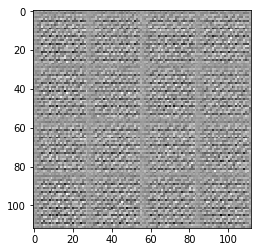

Epoch 1/2... Generator Loss: 1.0058 Discriminator Loss: 0.9574...
Epoch 1/2... Generator Loss: 1.6984 Discriminator Loss: 0.6130...
Epoch 1/2... Generator Loss: 1.4080 Discriminator Loss: 0.7291...
Epoch 1/2... Generator Loss: 2.3738 Discriminator Loss: 0.5626...
Epoch 1/2... Generator Loss: 1.9809 Discriminator Loss: 0.5741...
Epoch 1/2... Generator Loss: 1.8144 Discriminator Loss: 0.7936...
Epoch 1/2... Generator Loss: 1.1694 Discriminator Loss: 0.8849...
Epoch 1/2... Generator Loss: 1.1426 Discriminator Loss: 0.8255...
Epoch 1/2... Generator Loss: 0.5690 Discriminator Loss: 1.3391...
Epoch 1/2... Generator Loss: 0.3541 Discriminator Loss: 1.7443...


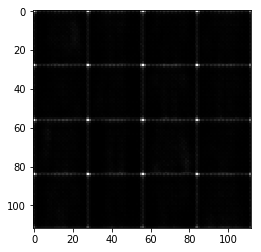

Epoch 1/2... Generator Loss: 1.7940 Discriminator Loss: 0.6369...
Epoch 1/2... Generator Loss: 0.5901 Discriminator Loss: 1.2557...
Epoch 1/2... Generator Loss: 0.3807 Discriminator Loss: 1.7118...
Epoch 1/2... Generator Loss: 0.3537 Discriminator Loss: 1.6981...
Epoch 1/2... Generator Loss: 0.3408 Discriminator Loss: 1.7061...
Epoch 1/2... Generator Loss: 0.7257 Discriminator Loss: 1.1490...
Epoch 1/2... Generator Loss: 0.7821 Discriminator Loss: 1.0573...
Epoch 1/2... Generator Loss: 2.6931 Discriminator Loss: 0.9623...
Epoch 1/2... Generator Loss: 1.1589 Discriminator Loss: 0.8247...
Epoch 1/2... Generator Loss: 0.4931 Discriminator Loss: 1.4959...


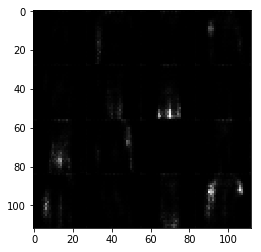

Epoch 1/2... Generator Loss: 1.1863 Discriminator Loss: 0.9077...
Epoch 1/2... Generator Loss: 2.6439 Discriminator Loss: 1.1381...
Epoch 1/2... Generator Loss: 1.8324 Discriminator Loss: 0.7514...
Epoch 1/2... Generator Loss: 0.4815 Discriminator Loss: 1.4385...
Epoch 1/2... Generator Loss: 0.8544 Discriminator Loss: 1.1370...
Epoch 1/2... Generator Loss: 0.8628 Discriminator Loss: 1.1364...
Epoch 1/2... Generator Loss: 0.6999 Discriminator Loss: 1.2010...
Epoch 1/2... Generator Loss: 1.2940 Discriminator Loss: 1.2863...
Epoch 1/2... Generator Loss: 0.5398 Discriminator Loss: 1.5298...
Epoch 1/2... Generator Loss: 1.1920 Discriminator Loss: 1.4023...


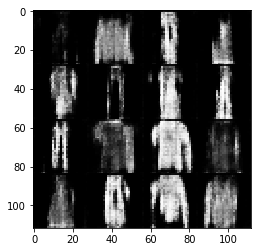

Epoch 1/2... Generator Loss: 0.8902 Discriminator Loss: 1.3263...
Epoch 1/2... Generator Loss: 0.6712 Discriminator Loss: 1.3580...
Epoch 1/2... Generator Loss: 1.0969 Discriminator Loss: 1.3659...
Epoch 1/2... Generator Loss: 0.5360 Discriminator Loss: 1.5983...
Epoch 1/2... Generator Loss: 0.4889 Discriminator Loss: 1.4825...
Epoch 1/2... Generator Loss: 1.5352 Discriminator Loss: 1.3844...
Epoch 1/2... Generator Loss: 0.7218 Discriminator Loss: 1.4057...
Epoch 1/2... Generator Loss: 1.2046 Discriminator Loss: 1.5931...
Epoch 1/2... Generator Loss: 0.4089 Discriminator Loss: 1.5351...
Epoch 1/2... Generator Loss: 0.3407 Discriminator Loss: 1.7048...


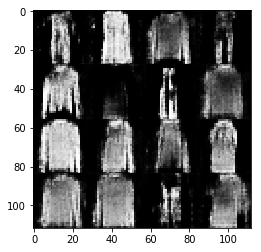

Epoch 1/2... Generator Loss: 0.5538 Discriminator Loss: 1.3639...
Epoch 1/2... Generator Loss: 0.4129 Discriminator Loss: 1.6303...
Epoch 1/2... Generator Loss: 0.3948 Discriminator Loss: 1.6822...
Epoch 1/2... Generator Loss: 0.8458 Discriminator Loss: 1.1982...
Epoch 1/2... Generator Loss: 0.7994 Discriminator Loss: 1.3051...
Epoch 1/2... Generator Loss: 1.1138 Discriminator Loss: 1.2443...
Epoch 1/2... Generator Loss: 0.5338 Discriminator Loss: 1.3788...
Epoch 1/2... Generator Loss: 0.5261 Discriminator Loss: 1.3971...
Epoch 1/2... Generator Loss: 0.4908 Discriminator Loss: 1.4336...
Epoch 1/2... Generator Loss: 0.5562 Discriminator Loss: 1.4028...


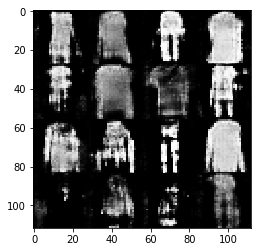

Epoch 1/2... Generator Loss: 0.2569 Discriminator Loss: 1.9304...
Epoch 1/2... Generator Loss: 0.4324 Discriminator Loss: 1.5728...
Epoch 1/2... Generator Loss: 0.2531 Discriminator Loss: 1.9557...
Epoch 1/2... Generator Loss: 0.6544 Discriminator Loss: 1.2778...
Epoch 1/2... Generator Loss: 0.9163 Discriminator Loss: 1.3698...
Epoch 1/2... Generator Loss: 0.6930 Discriminator Loss: 1.3608...
Epoch 1/2... Generator Loss: 0.7537 Discriminator Loss: 1.2934...
Epoch 1/2... Generator Loss: 0.5475 Discriminator Loss: 1.3827...
Epoch 1/2... Generator Loss: 0.8981 Discriminator Loss: 1.2670...
Epoch 1/2... Generator Loss: 0.7411 Discriminator Loss: 1.3444...


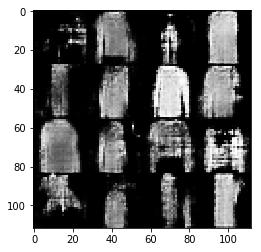

Epoch 1/2... Generator Loss: 1.0567 Discriminator Loss: 1.2905...
Epoch 1/2... Generator Loss: 0.4549 Discriminator Loss: 1.5235...
Epoch 1/2... Generator Loss: 0.5131 Discriminator Loss: 1.4296...
Epoch 1/2... Generator Loss: 0.5083 Discriminator Loss: 1.4788...
Epoch 1/2... Generator Loss: 0.5141 Discriminator Loss: 1.5832...
Epoch 1/2... Generator Loss: 0.3338 Discriminator Loss: 1.7172...
Epoch 1/2... Generator Loss: 0.6854 Discriminator Loss: 1.3554...
Epoch 1/2... Generator Loss: 0.3179 Discriminator Loss: 1.7643...
Epoch 1/2... Generator Loss: 0.4804 Discriminator Loss: 1.5618...
Epoch 1/2... Generator Loss: 0.2835 Discriminator Loss: 1.8624...


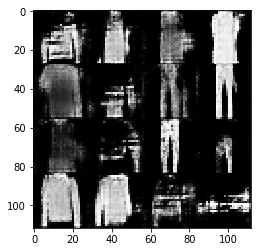

Epoch 1/2... Generator Loss: 0.5639 Discriminator Loss: 1.3827...
Epoch 1/2... Generator Loss: 0.8919 Discriminator Loss: 1.1837...
Epoch 1/2... Generator Loss: 0.4396 Discriminator Loss: 1.5070...
Epoch 1/2... Generator Loss: 0.6026 Discriminator Loss: 1.3528...
Epoch 1/2... Generator Loss: 1.0208 Discriminator Loss: 1.3282...
Epoch 1/2... Generator Loss: 0.6409 Discriminator Loss: 1.4089...
Epoch 1/2... Generator Loss: 0.5931 Discriminator Loss: 1.4761...
Epoch 1/2... Generator Loss: 0.4708 Discriminator Loss: 1.4883...
Epoch 1/2... Generator Loss: 0.9585 Discriminator Loss: 1.4276...
Epoch 1/2... Generator Loss: 0.4956 Discriminator Loss: 1.5114...


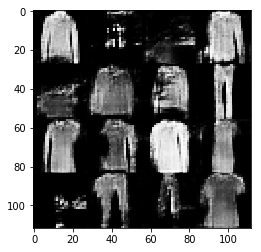

Epoch 1/2... Generator Loss: 0.6786 Discriminator Loss: 1.4612...
Epoch 1/2... Generator Loss: 0.4349 Discriminator Loss: 1.5721...
Epoch 1/2... Generator Loss: 0.5974 Discriminator Loss: 1.4589...
Epoch 1/2... Generator Loss: 0.3602 Discriminator Loss: 1.7120...
Epoch 1/2... Generator Loss: 0.9086 Discriminator Loss: 1.3292...
Epoch 1/2... Generator Loss: 0.7141 Discriminator Loss: 1.4029...
Epoch 1/2... Generator Loss: 0.6466 Discriminator Loss: 1.3481...
Epoch 1/2... Generator Loss: 0.5205 Discriminator Loss: 1.4344...
Epoch 1/2... Generator Loss: 0.5469 Discriminator Loss: 1.4303...
Epoch 1/2... Generator Loss: 0.7228 Discriminator Loss: 1.2792...


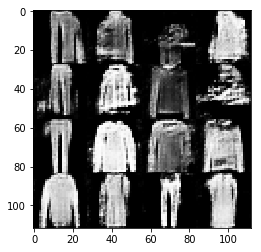

Epoch 1/2... Generator Loss: 0.4768 Discriminator Loss: 1.4440...
Epoch 1/2... Generator Loss: 0.3259 Discriminator Loss: 1.7295...
Epoch 1/2... Generator Loss: 0.4327 Discriminator Loss: 1.5387...
Epoch 1/2... Generator Loss: 0.7327 Discriminator Loss: 1.2978...
Epoch 1/2... Generator Loss: 0.6054 Discriminator Loss: 1.5128...
Epoch 1/2... Generator Loss: 0.3055 Discriminator Loss: 1.7776...
Epoch 1/2... Generator Loss: 0.7226 Discriminator Loss: 1.3758...
Epoch 1/2... Generator Loss: 0.5515 Discriminator Loss: 1.4455...
Epoch 1/2... Generator Loss: 0.9460 Discriminator Loss: 1.3001...
Epoch 1/2... Generator Loss: 0.7269 Discriminator Loss: 1.2917...


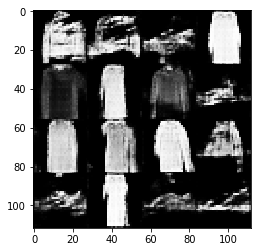

Epoch 1/2... Generator Loss: 1.2128 Discriminator Loss: 1.5110...
Epoch 1/2... Generator Loss: 0.7062 Discriminator Loss: 1.3577...
Epoch 1/2... Generator Loss: 1.0080 Discriminator Loss: 1.1140...
Epoch 1/2... Generator Loss: 0.9415 Discriminator Loss: 1.3551...
Epoch 1/2... Generator Loss: 1.2689 Discriminator Loss: 1.2411...
Epoch 1/2... Generator Loss: 0.6661 Discriminator Loss: 1.3904...
Epoch 1/2... Generator Loss: 0.7286 Discriminator Loss: 1.2565...
Epoch 1/2... Generator Loss: 0.7401 Discriminator Loss: 1.3750...
Epoch 1/2... Generator Loss: 0.2905 Discriminator Loss: 1.8265...
Epoch 1/2... Generator Loss: 0.3872 Discriminator Loss: 1.6736...


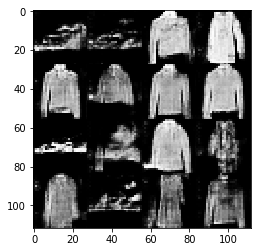

Epoch 1/2... Generator Loss: 1.3092 Discriminator Loss: 0.8768...
Epoch 1/2... Generator Loss: 1.5886 Discriminator Loss: 1.0968...
Epoch 1/2... Generator Loss: 1.5388 Discriminator Loss: 0.7432...
Epoch 1/2... Generator Loss: 1.1572 Discriminator Loss: 1.2816...
Epoch 1/2... Generator Loss: 1.1751 Discriminator Loss: 1.3890...
Epoch 1/2... Generator Loss: 0.5666 Discriminator Loss: 1.4825...
Epoch 1/2... Generator Loss: 1.1639 Discriminator Loss: 1.4548...
Epoch 1/2... Generator Loss: 0.2466 Discriminator Loss: 2.0398...
Epoch 1/2... Generator Loss: 0.4031 Discriminator Loss: 1.5979...
Epoch 1/2... Generator Loss: 1.0714 Discriminator Loss: 1.4800...


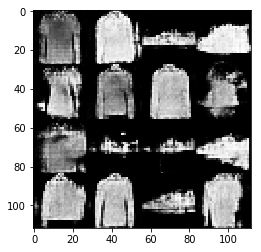

Epoch 1/2... Generator Loss: 0.7710 Discriminator Loss: 1.4745...
Epoch 1/2... Generator Loss: 0.4965 Discriminator Loss: 1.5101...
Epoch 1/2... Generator Loss: 0.7269 Discriminator Loss: 1.2131...
Epoch 1/2... Generator Loss: 0.9881 Discriminator Loss: 1.3396...
Epoch 1/2... Generator Loss: 1.1510 Discriminator Loss: 1.2701...
Epoch 1/2... Generator Loss: 0.9050 Discriminator Loss: 1.3906...
Epoch 1/2... Generator Loss: 0.7446 Discriminator Loss: 1.5619...
Epoch 1/2... Generator Loss: 1.0032 Discriminator Loss: 1.1848...
Epoch 1/2... Generator Loss: 0.6203 Discriminator Loss: 1.2545...
Epoch 1/2... Generator Loss: 0.7708 Discriminator Loss: 1.2802...


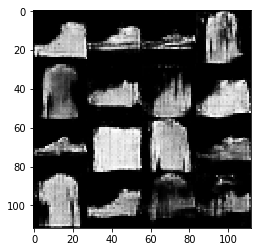

Epoch 1/2... Generator Loss: 0.9994 Discriminator Loss: 1.4970...
Epoch 1/2... Generator Loss: 0.8401 Discriminator Loss: 1.3017...
Epoch 1/2... Generator Loss: 0.8326 Discriminator Loss: 1.2518...
Epoch 1/2... Generator Loss: 1.1036 Discriminator Loss: 1.4379...
Epoch 1/2... Generator Loss: 0.8617 Discriminator Loss: 1.3330...
Epoch 1/2... Generator Loss: 0.6042 Discriminator Loss: 1.4822...
Epoch 1/2... Generator Loss: 1.1473 Discriminator Loss: 1.3434...
Epoch 1/2... Generator Loss: 1.2303 Discriminator Loss: 1.0260...
Epoch 1/2... Generator Loss: 0.5417 Discriminator Loss: 1.3916...
Epoch 1/2... Generator Loss: 0.5592 Discriminator Loss: 1.3985...


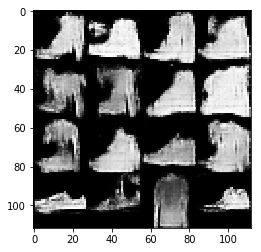

Epoch 1/2... Generator Loss: 0.4070 Discriminator Loss: 1.5356...
Epoch 1/2... Generator Loss: 0.7316 Discriminator Loss: 1.2671...
Epoch 1/2... Generator Loss: 0.5189 Discriminator Loss: 1.4212...
Epoch 1/2... Generator Loss: 0.8574 Discriminator Loss: 1.2496...
Epoch 1/2... Generator Loss: 0.8428 Discriminator Loss: 1.3229...
Epoch 1/2... Generator Loss: 0.7910 Discriminator Loss: 1.2734...
Epoch 1/2... Generator Loss: 0.3363 Discriminator Loss: 1.7056...
Epoch 1/2... Generator Loss: 0.4610 Discriminator Loss: 1.4968...
Epoch 1/2... Generator Loss: 0.4311 Discriminator Loss: 1.5045...
Epoch 1/2... Generator Loss: 1.2067 Discriminator Loss: 1.3407...


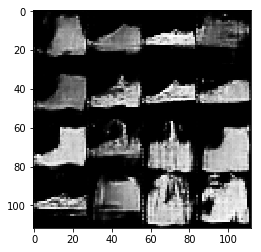

Epoch 1/2... Generator Loss: 0.5656 Discriminator Loss: 1.4007...
Epoch 1/2... Generator Loss: 0.7049 Discriminator Loss: 1.3555...
Epoch 1/2... Generator Loss: 0.5270 Discriminator Loss: 1.4472...
Epoch 1/2... Generator Loss: 0.9564 Discriminator Loss: 1.2368...
Epoch 1/2... Generator Loss: 0.4417 Discriminator Loss: 1.5582...
Epoch 1/2... Generator Loss: 0.8189 Discriminator Loss: 1.2700...
Epoch 1/2... Generator Loss: 0.3787 Discriminator Loss: 1.6455...
Epoch 1/2... Generator Loss: 0.9288 Discriminator Loss: 1.3413...
Epoch 1/2... Generator Loss: 0.4519 Discriminator Loss: 1.4535...
Epoch 1/2... Generator Loss: 0.5082 Discriminator Loss: 1.5895...


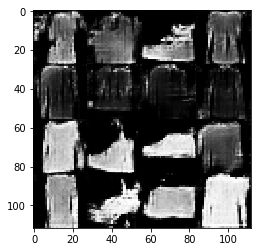

Epoch 1/2... Generator Loss: 0.6971 Discriminator Loss: 1.4160...
Epoch 1/2... Generator Loss: 0.8952 Discriminator Loss: 1.2937...
Epoch 1/2... Generator Loss: 1.1220 Discriminator Loss: 1.4547...
Epoch 1/2... Generator Loss: 0.5219 Discriminator Loss: 1.4643...
Epoch 1/2... Generator Loss: 0.3980 Discriminator Loss: 1.6409...
Epoch 1/2... Generator Loss: 0.3884 Discriminator Loss: 1.5929...
Epoch 1/2... Generator Loss: 0.7430 Discriminator Loss: 1.3366...
Epoch 1/2... Generator Loss: 0.4510 Discriminator Loss: 1.5815...
Epoch 1/2... Generator Loss: 0.3839 Discriminator Loss: 1.6362...
Epoch 1/2... Generator Loss: 0.3971 Discriminator Loss: 1.6450...


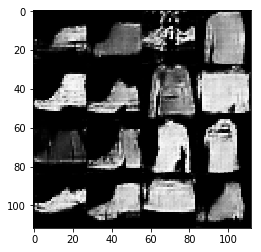

Epoch 1/2... Generator Loss: 0.4097 Discriminator Loss: 1.6138...
Epoch 1/2... Generator Loss: 0.6887 Discriminator Loss: 1.3757...
Epoch 1/2... Generator Loss: 0.5631 Discriminator Loss: 1.4111...
Epoch 1/2... Generator Loss: 0.5574 Discriminator Loss: 1.3573...
Epoch 1/2... Generator Loss: 0.4531 Discriminator Loss: 1.4745...
Epoch 1/2... Generator Loss: 0.4167 Discriminator Loss: 1.5653...
Epoch 1/2... Generator Loss: 1.2414 Discriminator Loss: 1.2515...
Epoch 1/2... Generator Loss: 0.4796 Discriminator Loss: 1.4667...
Epoch 1/2... Generator Loss: 0.8236 Discriminator Loss: 1.2423...
Epoch 1/2... Generator Loss: 0.3863 Discriminator Loss: 1.6007...


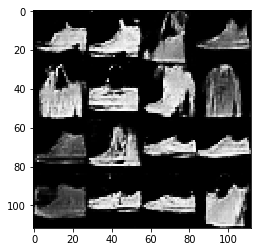

Epoch 1/2... Generator Loss: 0.4518 Discriminator Loss: 1.5527...
Epoch 1/2... Generator Loss: 0.4531 Discriminator Loss: 1.4762...
Epoch 1/2... Generator Loss: 0.4712 Discriminator Loss: 1.4175...
Epoch 1/2... Generator Loss: 0.7853 Discriminator Loss: 1.4049...
Epoch 1/2... Generator Loss: 0.2381 Discriminator Loss: 2.0349...
Epoch 1/2... Generator Loss: 1.0218 Discriminator Loss: 1.0099...
Epoch 1/2... Generator Loss: 2.9483 Discriminator Loss: 1.8458...
Epoch 2/2... Generator Loss: 2.2800 Discriminator Loss: 0.6565...
Epoch 2/2... Generator Loss: 1.8302 Discriminator Loss: 0.6567...
Epoch 2/2... Generator Loss: 2.4244 Discriminator Loss: 0.5348...


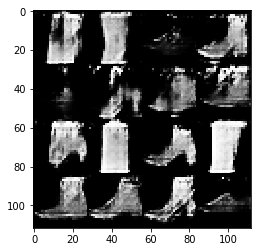

Epoch 2/2... Generator Loss: 1.7953 Discriminator Loss: 0.6682...
Epoch 2/2... Generator Loss: 2.6764 Discriminator Loss: 1.1239...
Epoch 2/2... Generator Loss: 1.6762 Discriminator Loss: 0.6801...
Epoch 2/2... Generator Loss: 1.9148 Discriminator Loss: 0.8793...
Epoch 2/2... Generator Loss: 1.2249 Discriminator Loss: 0.8088...
Epoch 2/2... Generator Loss: 0.8804 Discriminator Loss: 1.0345...
Epoch 2/2... Generator Loss: 1.6854 Discriminator Loss: 1.0405...
Epoch 2/2... Generator Loss: 0.4448 Discriminator Loss: 1.5155...
Epoch 2/2... Generator Loss: 0.7755 Discriminator Loss: 1.0945...
Epoch 2/2... Generator Loss: 0.5134 Discriminator Loss: 1.3490...


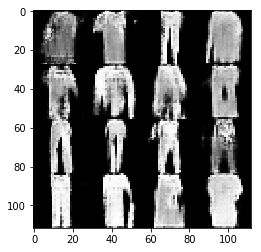

Epoch 2/2... Generator Loss: 0.9183 Discriminator Loss: 1.0378...
Epoch 2/2... Generator Loss: 0.7851 Discriminator Loss: 1.1742...
Epoch 2/2... Generator Loss: 0.5807 Discriminator Loss: 1.3114...
Epoch 2/2... Generator Loss: 0.2875 Discriminator Loss: 1.8301...
Epoch 2/2... Generator Loss: 0.6173 Discriminator Loss: 1.2450...
Epoch 2/2... Generator Loss: 0.4737 Discriminator Loss: 1.4016...
Epoch 2/2... Generator Loss: 0.9219 Discriminator Loss: 1.1346...
Epoch 2/2... Generator Loss: 1.4258 Discriminator Loss: 1.4471...
Epoch 2/2... Generator Loss: 0.6762 Discriminator Loss: 1.4456...
Epoch 2/2... Generator Loss: 0.6087 Discriminator Loss: 1.2949...


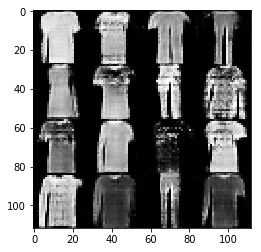

Epoch 2/2... Generator Loss: 1.3170 Discriminator Loss: 1.3706...
Epoch 2/2... Generator Loss: 0.4586 Discriminator Loss: 1.5553...
Epoch 2/2... Generator Loss: 1.0255 Discriminator Loss: 1.1692...
Epoch 2/2... Generator Loss: 0.6140 Discriminator Loss: 1.5093...
Epoch 2/2... Generator Loss: 0.3160 Discriminator Loss: 1.7798...
Epoch 2/2... Generator Loss: 0.5549 Discriminator Loss: 1.4053...
Epoch 2/2... Generator Loss: 0.2827 Discriminator Loss: 1.8512...
Epoch 2/2... Generator Loss: 0.4356 Discriminator Loss: 1.5825...
Epoch 2/2... Generator Loss: 0.8653 Discriminator Loss: 1.3098...
Epoch 2/2... Generator Loss: 0.3781 Discriminator Loss: 1.5967...


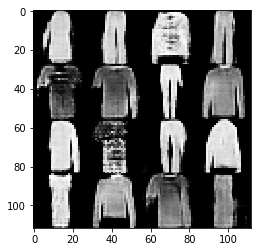

Epoch 2/2... Generator Loss: 0.6894 Discriminator Loss: 1.2503...
Epoch 2/2... Generator Loss: 0.9063 Discriminator Loss: 1.1094...
Epoch 2/2... Generator Loss: 0.2677 Discriminator Loss: 1.8898...
Epoch 2/2... Generator Loss: 0.5747 Discriminator Loss: 1.4949...
Epoch 2/2... Generator Loss: 0.7460 Discriminator Loss: 1.1848...
Epoch 2/2... Generator Loss: 0.6819 Discriminator Loss: 1.2087...
Epoch 2/2... Generator Loss: 0.6463 Discriminator Loss: 1.2700...
Epoch 2/2... Generator Loss: 0.7135 Discriminator Loss: 1.2393...
Epoch 2/2... Generator Loss: 0.7673 Discriminator Loss: 1.1409...
Epoch 2/2... Generator Loss: 0.9119 Discriminator Loss: 1.2264...


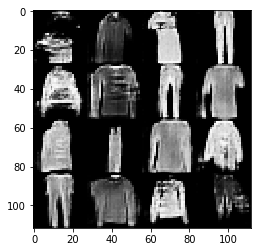

Epoch 2/2... Generator Loss: 0.7233 Discriminator Loss: 1.2905...
Epoch 2/2... Generator Loss: 0.4721 Discriminator Loss: 1.4442...
Epoch 2/2... Generator Loss: 1.0087 Discriminator Loss: 1.1587...
Epoch 2/2... Generator Loss: 0.9407 Discriminator Loss: 1.0946...
Epoch 2/2... Generator Loss: 0.7609 Discriminator Loss: 1.2267...
Epoch 2/2... Generator Loss: 0.9150 Discriminator Loss: 1.1317...
Epoch 2/2... Generator Loss: 0.5264 Discriminator Loss: 1.3948...
Epoch 2/2... Generator Loss: 1.1246 Discriminator Loss: 1.1226...
Epoch 2/2... Generator Loss: 0.8436 Discriminator Loss: 1.2556...
Epoch 2/2... Generator Loss: 1.0003 Discriminator Loss: 1.2688...


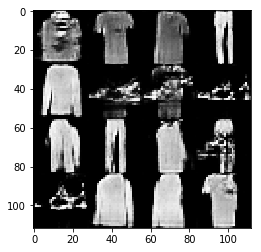

Epoch 2/2... Generator Loss: 0.6572 Discriminator Loss: 1.2464...
Epoch 2/2... Generator Loss: 0.4065 Discriminator Loss: 1.5707...
Epoch 2/2... Generator Loss: 0.8591 Discriminator Loss: 1.2641...
Epoch 2/2... Generator Loss: 0.9448 Discriminator Loss: 1.1355...
Epoch 2/2... Generator Loss: 0.7613 Discriminator Loss: 1.2362...
Epoch 2/2... Generator Loss: 0.6406 Discriminator Loss: 1.2106...
Epoch 2/2... Generator Loss: 0.5811 Discriminator Loss: 1.4163...
Epoch 2/2... Generator Loss: 0.4645 Discriminator Loss: 1.5430...
Epoch 2/2... Generator Loss: 0.9233 Discriminator Loss: 1.1324...
Epoch 2/2... Generator Loss: 0.8043 Discriminator Loss: 1.1310...


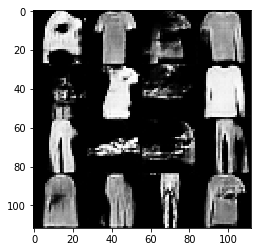

Epoch 2/2... Generator Loss: 0.6130 Discriminator Loss: 1.3219...
Epoch 2/2... Generator Loss: 0.4899 Discriminator Loss: 1.3981...
Epoch 2/2... Generator Loss: 0.4453 Discriminator Loss: 1.4722...
Epoch 2/2... Generator Loss: 0.8438 Discriminator Loss: 1.1400...
Epoch 2/2... Generator Loss: 0.5955 Discriminator Loss: 1.3498...
Epoch 2/2... Generator Loss: 0.7162 Discriminator Loss: 1.1829...
Epoch 2/2... Generator Loss: 0.9305 Discriminator Loss: 1.2771...
Epoch 2/2... Generator Loss: 1.0417 Discriminator Loss: 1.1197...
Epoch 2/2... Generator Loss: 0.9705 Discriminator Loss: 1.0872...
Epoch 2/2... Generator Loss: 0.5121 Discriminator Loss: 1.4180...


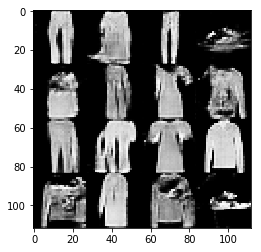

Epoch 2/2... Generator Loss: 0.5999 Discriminator Loss: 1.3216...
Epoch 2/2... Generator Loss: 0.9274 Discriminator Loss: 1.2018...
Epoch 2/2... Generator Loss: 0.8857 Discriminator Loss: 1.1454...
Epoch 2/2... Generator Loss: 1.1010 Discriminator Loss: 1.2847...
Epoch 2/2... Generator Loss: 0.6939 Discriminator Loss: 1.2498...
Epoch 2/2... Generator Loss: 0.4457 Discriminator Loss: 1.5086...
Epoch 2/2... Generator Loss: 0.6303 Discriminator Loss: 1.3993...
Epoch 2/2... Generator Loss: 0.3344 Discriminator Loss: 1.7438...
Epoch 2/2... Generator Loss: 1.1034 Discriminator Loss: 1.1714...
Epoch 2/2... Generator Loss: 0.5296 Discriminator Loss: 1.3859...


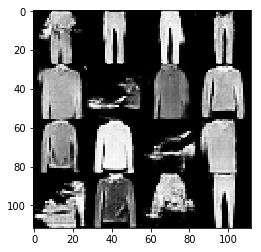

Epoch 2/2... Generator Loss: 0.4792 Discriminator Loss: 1.4799...
Epoch 2/2... Generator Loss: 0.4899 Discriminator Loss: 1.4647...
Epoch 2/2... Generator Loss: 0.6468 Discriminator Loss: 1.3181...
Epoch 2/2... Generator Loss: 0.8848 Discriminator Loss: 1.3209...
Epoch 2/2... Generator Loss: 0.5056 Discriminator Loss: 1.4499...
Epoch 2/2... Generator Loss: 0.6885 Discriminator Loss: 1.2781...
Epoch 2/2... Generator Loss: 0.5076 Discriminator Loss: 1.4339...
Epoch 2/2... Generator Loss: 0.3916 Discriminator Loss: 1.6787...
Epoch 2/2... Generator Loss: 0.4374 Discriminator Loss: 1.4853...
Epoch 2/2... Generator Loss: 0.7711 Discriminator Loss: 1.1892...


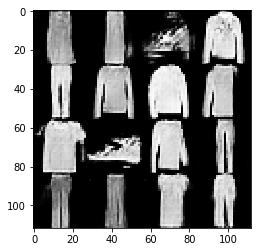

Epoch 2/2... Generator Loss: 0.3553 Discriminator Loss: 1.6803...
Epoch 2/2... Generator Loss: 0.8023 Discriminator Loss: 1.2104...
Epoch 2/2... Generator Loss: 0.4189 Discriminator Loss: 1.5642...
Epoch 2/2... Generator Loss: 1.1919 Discriminator Loss: 1.3574...
Epoch 2/2... Generator Loss: 0.6818 Discriminator Loss: 1.2668...
Epoch 2/2... Generator Loss: 0.7902 Discriminator Loss: 1.4108...
Epoch 2/2... Generator Loss: 0.4223 Discriminator Loss: 1.5926...
Epoch 2/2... Generator Loss: 1.1639 Discriminator Loss: 1.3778...
Epoch 2/2... Generator Loss: 0.3238 Discriminator Loss: 1.7776...
Epoch 2/2... Generator Loss: 0.6472 Discriminator Loss: 1.3228...


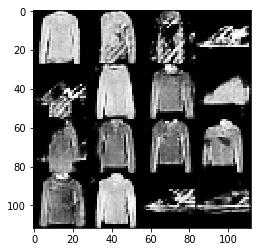

Epoch 2/2... Generator Loss: 0.5293 Discriminator Loss: 1.3213...
Epoch 2/2... Generator Loss: 0.5286 Discriminator Loss: 1.4680...
Epoch 2/2... Generator Loss: 0.3600 Discriminator Loss: 1.7929...
Epoch 2/2... Generator Loss: 1.1367 Discriminator Loss: 1.1957...
Epoch 2/2... Generator Loss: 1.0457 Discriminator Loss: 1.1623...
Epoch 2/2... Generator Loss: 0.6583 Discriminator Loss: 1.2704...
Epoch 2/2... Generator Loss: 0.3334 Discriminator Loss: 1.7280...
Epoch 2/2... Generator Loss: 0.4785 Discriminator Loss: 1.4449...
Epoch 2/2... Generator Loss: 1.4023 Discriminator Loss: 1.0055...
Epoch 2/2... Generator Loss: 2.2005 Discriminator Loss: 1.2930...


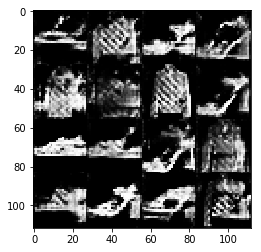

Epoch 2/2... Generator Loss: 1.1224 Discriminator Loss: 0.9408...
Epoch 2/2... Generator Loss: 1.8343 Discriminator Loss: 1.3094...
Epoch 2/2... Generator Loss: 0.3930 Discriminator Loss: 1.6299...
Epoch 2/2... Generator Loss: 1.3877 Discriminator Loss: 1.1176...
Epoch 2/2... Generator Loss: 1.6273 Discriminator Loss: 0.8664...
Epoch 2/2... Generator Loss: 0.5453 Discriminator Loss: 1.4177...
Epoch 2/2... Generator Loss: 0.4673 Discriminator Loss: 1.4749...
Epoch 2/2... Generator Loss: 0.9190 Discriminator Loss: 1.2742...
Epoch 2/2... Generator Loss: 0.4333 Discriminator Loss: 1.5607...
Epoch 2/2... Generator Loss: 0.5806 Discriminator Loss: 1.3317...


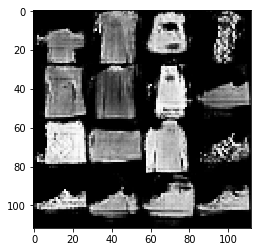

Epoch 2/2... Generator Loss: 0.2698 Discriminator Loss: 1.9197...
Epoch 2/2... Generator Loss: 0.7314 Discriminator Loss: 1.1074...
Epoch 2/2... Generator Loss: 1.0688 Discriminator Loss: 1.2721...
Epoch 2/2... Generator Loss: 1.2256 Discriminator Loss: 1.1395...
Epoch 2/2... Generator Loss: 1.1029 Discriminator Loss: 1.2503...
Epoch 2/2... Generator Loss: 0.6311 Discriminator Loss: 1.2180...
Epoch 2/2... Generator Loss: 0.4508 Discriminator Loss: 1.4879...
Epoch 2/2... Generator Loss: 0.3650 Discriminator Loss: 1.6941...
Epoch 2/2... Generator Loss: 0.9248 Discriminator Loss: 1.2313...
Epoch 2/2... Generator Loss: 0.8523 Discriminator Loss: 1.1053...


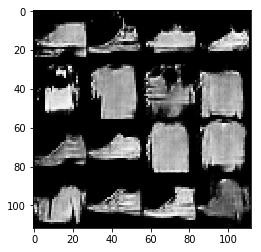

Epoch 2/2... Generator Loss: 0.3736 Discriminator Loss: 1.6695...
Epoch 2/2... Generator Loss: 0.4822 Discriminator Loss: 1.4726...
Epoch 2/2... Generator Loss: 0.4066 Discriminator Loss: 1.5888...
Epoch 2/2... Generator Loss: 0.5581 Discriminator Loss: 1.4016...
Epoch 2/2... Generator Loss: 0.9604 Discriminator Loss: 1.1149...
Epoch 2/2... Generator Loss: 1.2385 Discriminator Loss: 0.9932...
Epoch 2/2... Generator Loss: 0.8507 Discriminator Loss: 1.3781...
Epoch 2/2... Generator Loss: 0.7883 Discriminator Loss: 1.1554...
Epoch 2/2... Generator Loss: 0.3226 Discriminator Loss: 1.7460...
Epoch 2/2... Generator Loss: 0.4143 Discriminator Loss: 1.5139...


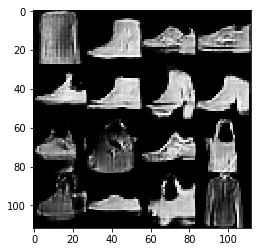

Epoch 2/2... Generator Loss: 0.8481 Discriminator Loss: 1.3917...
Epoch 2/2... Generator Loss: 0.6275 Discriminator Loss: 1.3353...
Epoch 2/2... Generator Loss: 1.1921 Discriminator Loss: 1.2572...
Epoch 2/2... Generator Loss: 0.5242 Discriminator Loss: 1.4327...
Epoch 2/2... Generator Loss: 0.3505 Discriminator Loss: 1.7237...
Epoch 2/2... Generator Loss: 0.4079 Discriminator Loss: 1.5567...
Epoch 2/2... Generator Loss: 0.6778 Discriminator Loss: 1.2626...
Epoch 2/2... Generator Loss: 0.4166 Discriminator Loss: 1.5476...
Epoch 2/2... Generator Loss: 0.2978 Discriminator Loss: 1.8122...
Epoch 2/2... Generator Loss: 0.6061 Discriminator Loss: 1.3695...


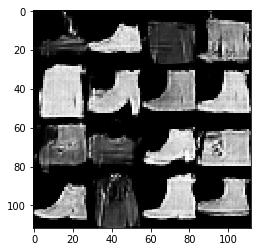

Epoch 2/2... Generator Loss: 0.6508 Discriminator Loss: 1.3480...
Epoch 2/2... Generator Loss: 0.7351 Discriminator Loss: 1.1651...
Epoch 2/2... Generator Loss: 0.7982 Discriminator Loss: 1.3289...
Epoch 2/2... Generator Loss: 1.4437 Discriminator Loss: 1.4464...
Epoch 2/2... Generator Loss: 0.8134 Discriminator Loss: 1.3306...
Epoch 2/2... Generator Loss: 1.0116 Discriminator Loss: 1.2548...
Epoch 2/2... Generator Loss: 1.0683 Discriminator Loss: 1.2686...
Epoch 2/2... Generator Loss: 0.7340 Discriminator Loss: 1.2409...
Epoch 2/2... Generator Loss: 0.4777 Discriminator Loss: 1.5129...
Epoch 2/2... Generator Loss: 0.9045 Discriminator Loss: 1.4222...


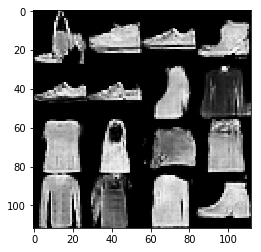

Epoch 2/2... Generator Loss: 0.4536 Discriminator Loss: 1.5119...
Epoch 2/2... Generator Loss: 0.5107 Discriminator Loss: 1.4632...
Epoch 2/2... Generator Loss: 0.6637 Discriminator Loss: 1.4118...
Epoch 2/2... Generator Loss: 0.9535 Discriminator Loss: 1.2830...
Epoch 2/2... Generator Loss: 0.4374 Discriminator Loss: 1.4957...
Epoch 2/2... Generator Loss: 0.3613 Discriminator Loss: 1.6407...
Epoch 2/2... Generator Loss: 0.5223 Discriminator Loss: 1.5014...
Epoch 2/2... Generator Loss: 1.3441 Discriminator Loss: 1.2240...
Epoch 2/2... Generator Loss: 0.7079 Discriminator Loss: 1.2601...
Epoch 2/2... Generator Loss: 0.3988 Discriminator Loss: 1.5966...


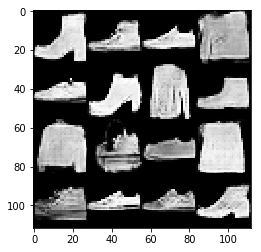

Epoch 2/2... Generator Loss: 0.6476 Discriminator Loss: 1.4188...
Epoch 2/2... Generator Loss: 1.3574 Discriminator Loss: 1.4799...
Epoch 2/2... Generator Loss: 0.8779 Discriminator Loss: 1.2753...
Epoch 2/2... Generator Loss: 0.8907 Discriminator Loss: 1.2437...
Epoch 2/2... Generator Loss: 0.7295 Discriminator Loss: 1.2391...
Epoch 2/2... Generator Loss: 0.5140 Discriminator Loss: 1.3834...
Epoch 2/2... Generator Loss: 0.4862 Discriminator Loss: 1.4662...
Epoch 2/2... Generator Loss: 1.0665 Discriminator Loss: 1.2634...
Epoch 2/2... Generator Loss: 0.7181 Discriminator Loss: 1.4545...
Epoch 2/2... Generator Loss: 1.3739 Discriminator Loss: 1.2528...


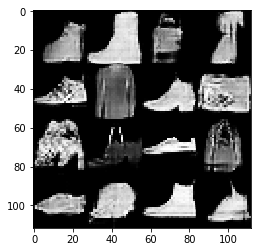

Epoch 2/2... Generator Loss: 1.0707 Discriminator Loss: 1.2442...
Epoch 2/2... Generator Loss: 0.9646 Discriminator Loss: 1.2093...
Epoch 2/2... Generator Loss: 1.0115 Discriminator Loss: 1.0558...
Epoch 2/2... Generator Loss: 1.6060 Discriminator Loss: 0.6937...
Epoch 2/2... Generator Loss: 0.4945 Discriminator Loss: 1.4425...


In [108]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.1
epochs = 2

data =  glob.glob('data/all/*.png')
data_shape = len(data),28,28,1
imagemode = 'L'



with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, get_batches,
          data_shape, 'L')

As we can see the generator model has learnt to generate new similar images on its own. The model takes random noise as input and generates the image